In [23]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../src').resolve()))
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from matplotlib import cm
from matplotlib.colors import Normalize
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from preprocessing import BagOfNotes, PreprocessMidiDataFrame, MidiPathToDataFrame, MidiPathToPrettyMidi
import evaluation
from visualizations import plot_piano_roll, plot_note_density, plot_pitch_histogram, visualize_song


In [5]:
models = pickle.load(open("nbon-pca2.pkl", "rb"))

In [7]:
print(models)


Pipeline(steps=[('nBoN', BagOfNotes(normalize=True)),
                ('PCA2', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=20, n_init=10, random_state=283080))])


In [8]:
maestro_path = Path('../maestro/maestro-v3.0.0/')
df = pd.read_csv('../eda/no_dups.csv')
train = df[df.split == 'train']
test = df[df.split == 'test']

pipe = Pipeline([
    ('loader', MidiPathToDataFrame(maestro_path)),
    ('cleaner', PreprocessMidiDataFrame()),
])
train_loaded = pipe.transform(train.midi_filename)
test_loaded = pipe.transform(test.midi_filename)

/Users/paulinacucalon/Desktop/OMS/ISYE 6740/PROJECT/melodies_1/vmelodies/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/paulinacucalon/Desktop/OMS/ISYE 6740/PROJECT/melodies_1/vmelodies/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [9]:
bitmidi_folder = Path('../data/')
bitmidi_files = [f for f in os.listdir(bitmidi_folder) if f.endswith(".mid")]
bitmidi_raw = Pipeline([
    ('loader', MidiPathToDataFrame(bitmidi_folder)),
    ('cleaner', PreprocessMidiDataFrame())
]).transform(bitmidi_files)

/Users/paulinacucalon/Desktop/OMS/ISYE 6740/PROJECT/melodies_1/vmelodies/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [11]:
bitmidi_embeds = models[:2].transform(bitmidi_raw)
maestro_embeds = models[:2].transform(test_loaded)
bitmidi_clusters = models.named_steps['kmeans'].predict(bitmidi_embeds)
maestro_clusters = models.named_steps['kmeans'].predict(maestro_embeds)
comparison_data = []

for i, bit_embed in enumerate(bitmidi_embeds):
    bit_cluster = bitmidi_clusters[i]
    same_cluster_indices = np.where(maestro_clusters == bit_cluster)[0]
    same_cluster_embeds = maestro_embeds[same_cluster_indices]
    dists = np.linalg.norm(same_cluster_embeds - bit_embed, axis=1)
    sorted_indices = np.argsort(dists)
    closest_idxs = same_cluster_indices[sorted_indices[:2]]
    furthest_idxs = same_cluster_indices[sorted_indices[-2:]]
    for label, idx in zip(['closest_1', 'closest_2', 'furthest_1', 'furthest_2'], list(closest_idxs) + list(furthest_idxs)):
        comparison_data.append({
            'bitmidi_song': bitmidi_files[i],
            'maestro_song': test.iloc[idx]['canonical_title'],
            'cluster': bit_cluster,
            'distance': np.linalg.norm(maestro_embeds[idx] - bit_embed),
            'relation': label
        })


In [12]:
df_compare = pd.DataFrame(comparison_data)
display(df_compare)

,bitmidi_song,maestro_song,cluster,distance,relation
0,Backstreet Boys - I Want It That Way.mid,"Fantasy in F-sharp Minor, Op. 28 (Complete)",11,0.034819,closest_1
1,Backstreet Boys - I Want It That Way.mid,"Sonata in A Major, D. 664, I. Allegro moderato",11,0.042515,closest_2
2,Backstreet Boys - I Want It That Way.mid,"Sonata in E Major, Op. 14, No. 1",11,0.054785,furthest_1
3,Backstreet Boys - I Want It That Way.mid,"Sonata No. 15 in D Major, Op. 28, I. Allegro",11,0.065974,furthest_2
4,Super Mario 64 - Medley.mid,"Sonata in C Major, Op. 2 No. 3, 1st mov.",19,0.006842,closest_1
5,Super Mario 64 - Medley.mid,"Sonata No. 3 in C Major, Op. 2 No. 3, First Mo...",19,0.007973,closest_2
6,Super Mario 64 - Medley.mid,"Sonata No. 10 in G Major, Op. 14 No. 2, First ...",19,0.023139,furthest_1
7,Super Mario 64 - Medley.mid,"Sonata in D Minor, K. 213",19,0.031214,furthest_2
8,Never-Gonna-Give-You-Up-3.mid,"Prelude and Fugue in D-sharp Minor, WTC II, BW...",15,0.013010,closest_1
9,Never-Gonna-Give-You-Up-3.mid,"Valse brillante No. 1 in A-flat Major, Op. 34",15,0.020490,closest_2


/var/folders/_3/z0_712995xv71srz8s868tkh0000gn/T/ipykernel_54029/3250561601.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")


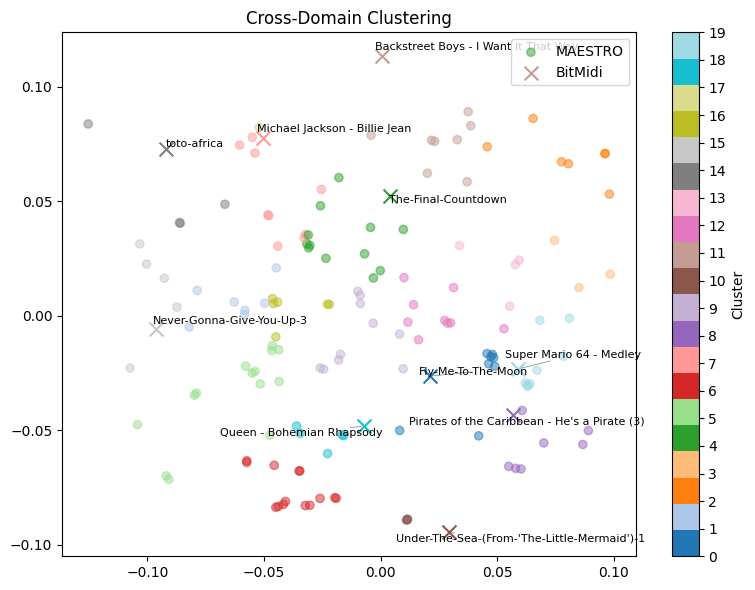

In [14]:
cmap = cm.get_cmap("tab20")
norm = Normalize(vmin=0, vmax=19)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    maestro_embeds[:, 0], maestro_embeds[:, 1],
    c=maestro_clusters,
    cmap=cmap,
    norm=norm,
    alpha=0.5,
    label='MAESTRO'
)
texts = []
for i, (x, y) in enumerate(bitmidi_embeds):
    ax.scatter(
        x, y,
        color=cmap(norm(bitmidi_clusters[i])),
        marker='x',
        s=100,
        label='BitMidi' if i == 0 else ""
    )
    texts.append(ax.text(x, y, bitmidi_files[i].replace('.mid', ''), fontsize=8))
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
ax.set_title("Cross-Domain Clustering")
ax.legend(loc='upper right')
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, ticks=range(20), label='Cluster')
plt.tight_layout()
plt.show()


In [15]:
cluster_min = df_compare[df_compare['relation'].str.contains("closest")].groupby("cluster")["distance"].min()
cluster_max = df_compare[df_compare['relation'].str.contains("furthest")].groupby("cluster")["distance"].max()
closest_cluster = cluster_min.idxmin()
furthest_cluster = cluster_max.idxmax()
print("Closest Cluster:", closest_cluster)
print("Furthest Cluster:", furthest_cluster)


Closest Cluster: 8
Furthest Cluster: 11


In [17]:
chosen_clusters = [closest_cluster, furthest_cluster]
selected_rows = df_compare[df_compare["cluster"].isin(chosen_clusters)]

In [24]:
bitmidi_pretty = MidiPathToPrettyMidi(bitmidi_folder).transform(bitmidi_files)
pretty_test = MidiPathToPrettyMidi(maestro_path).transform(test.midi_filename)


Cluster 11 - BitMidi Song: Backstreet Boys - I Want It That Way
BitMidi: Backstreet Boys - I Want It That Way.mid


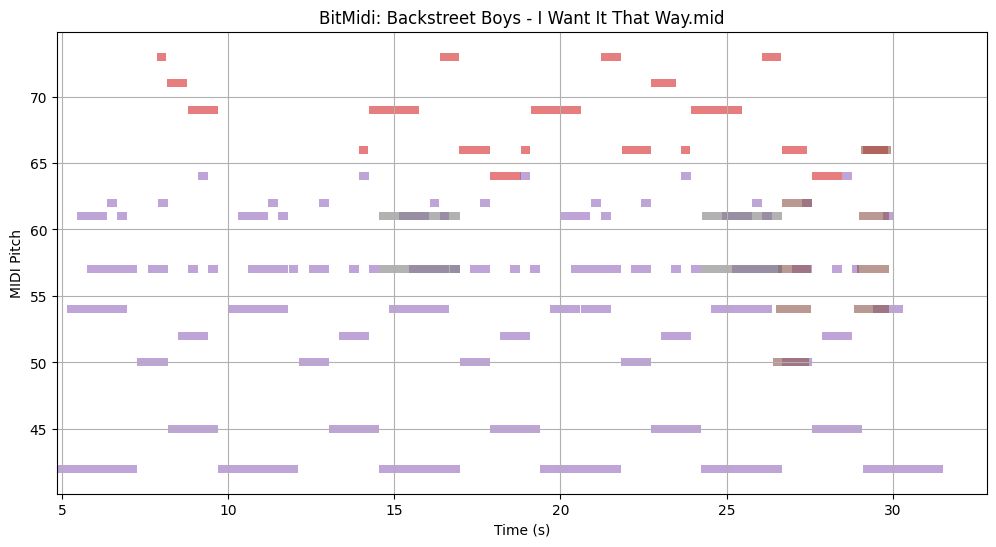

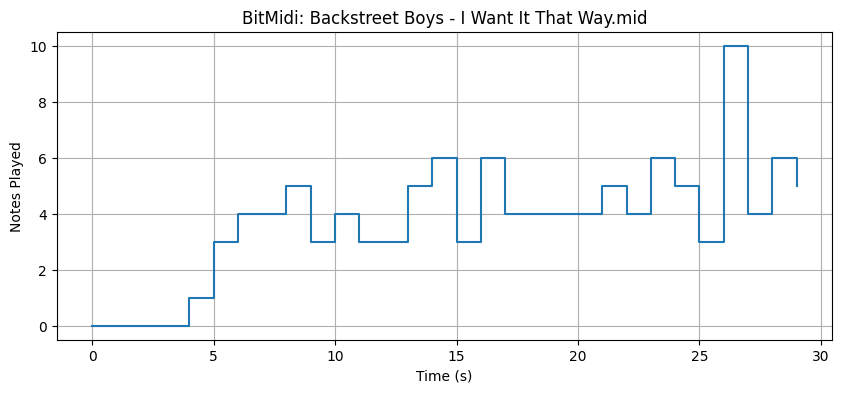

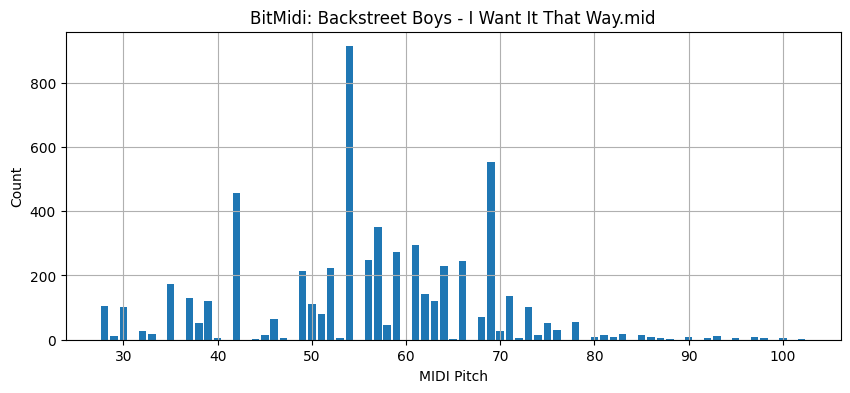

  Closest 1: Fantasy in F-sharp Minor, Op. 28 (Complete)


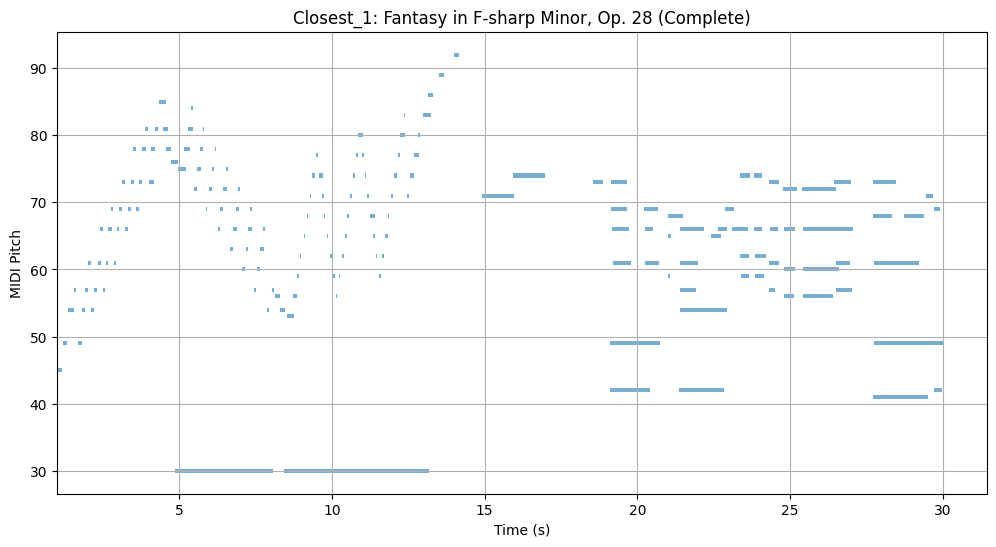

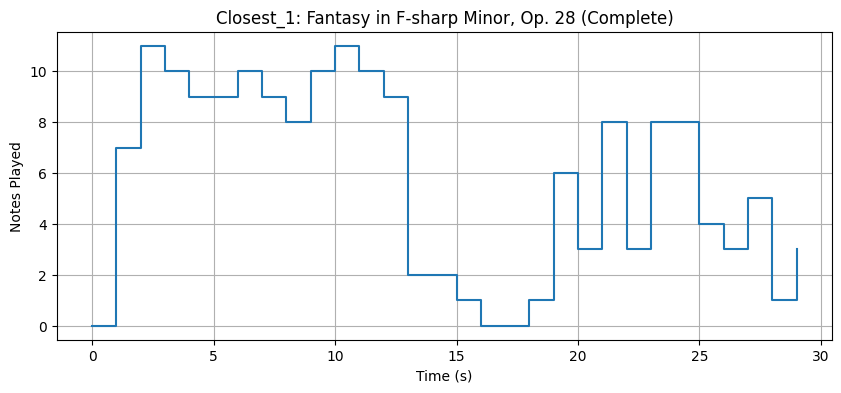

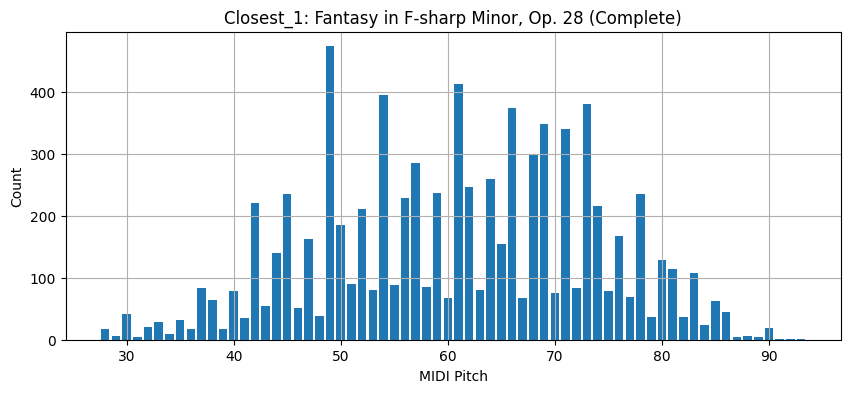

  Closest 2: Sonata in A Major, D. 664, I. Allegro moderato


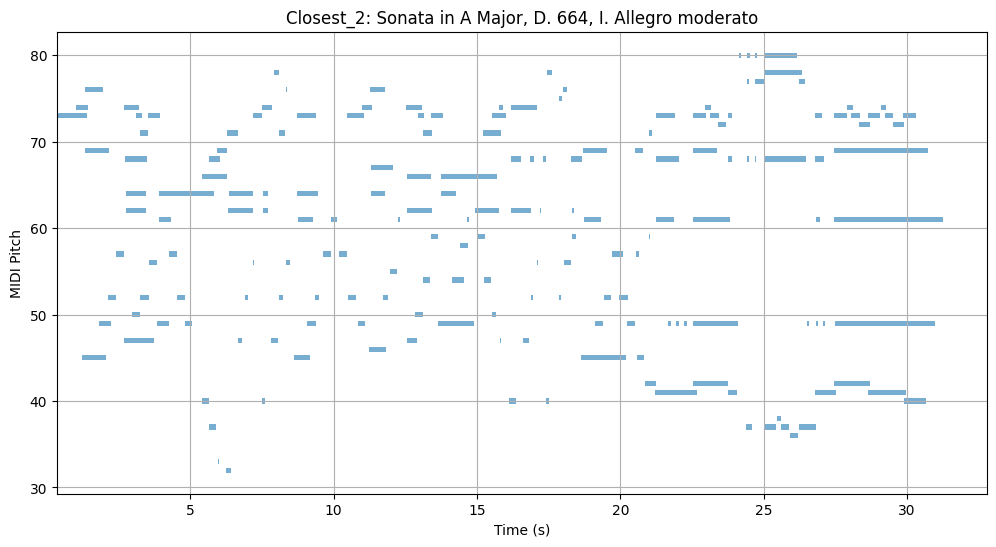

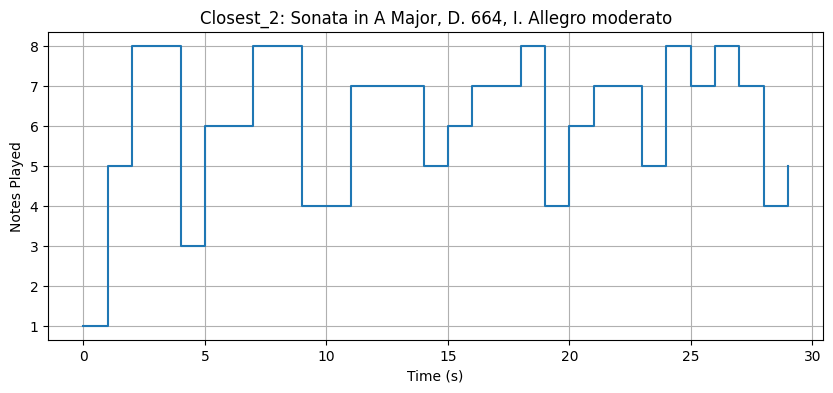

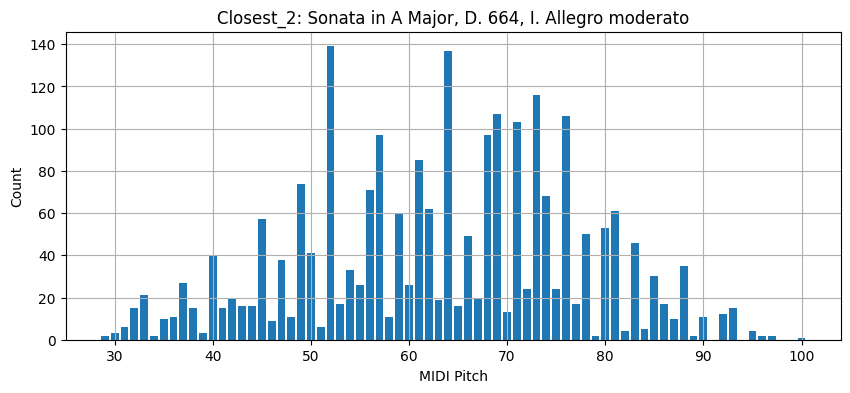

  Furthest 1: Sonata in E Major, Op. 14, No. 1


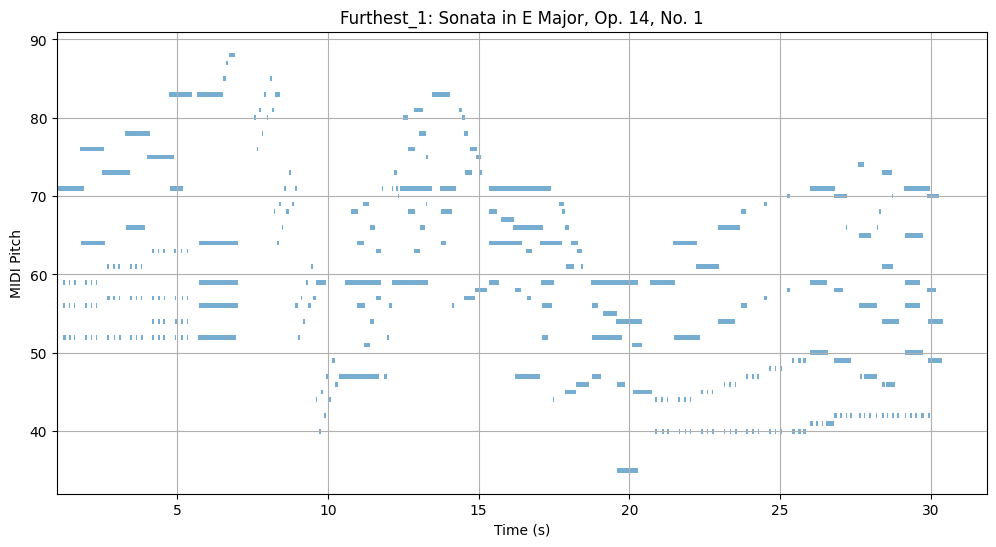

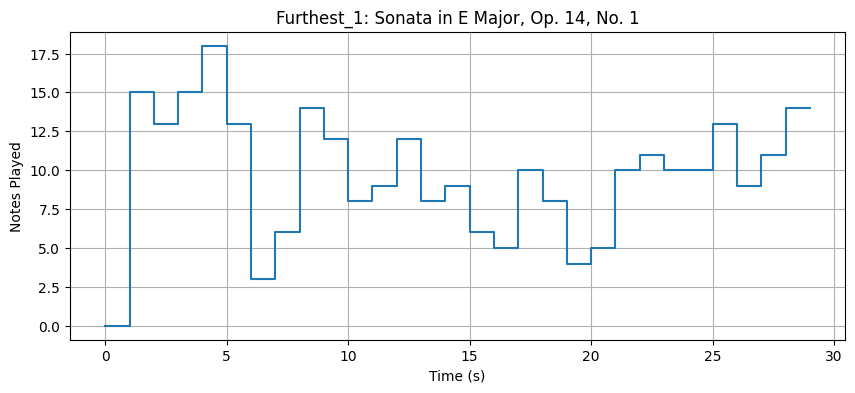

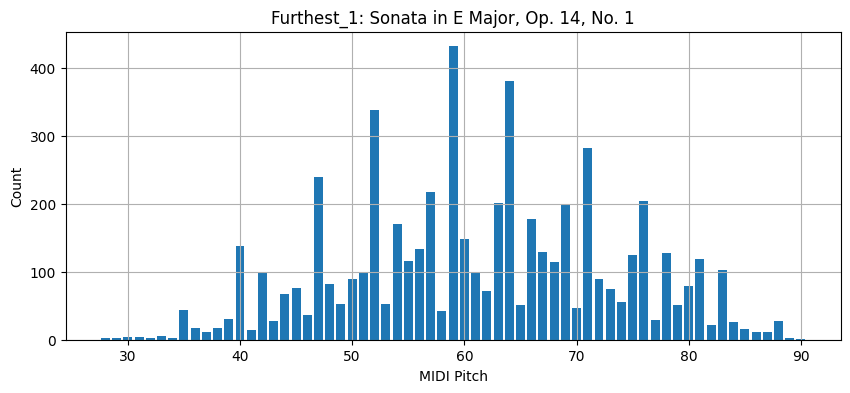

  Furthest 2: Sonata No. 15 in D Major, Op. 28, I. Allegro


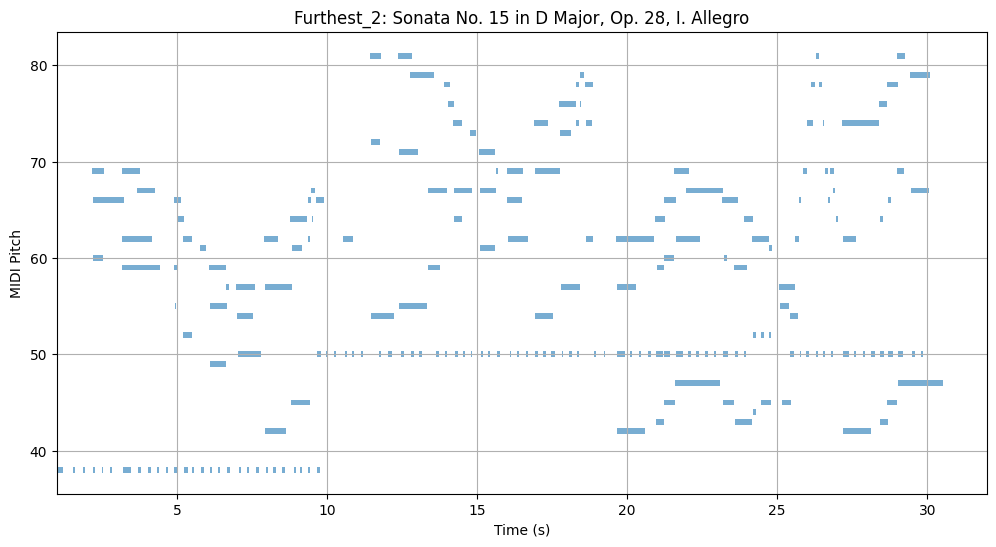

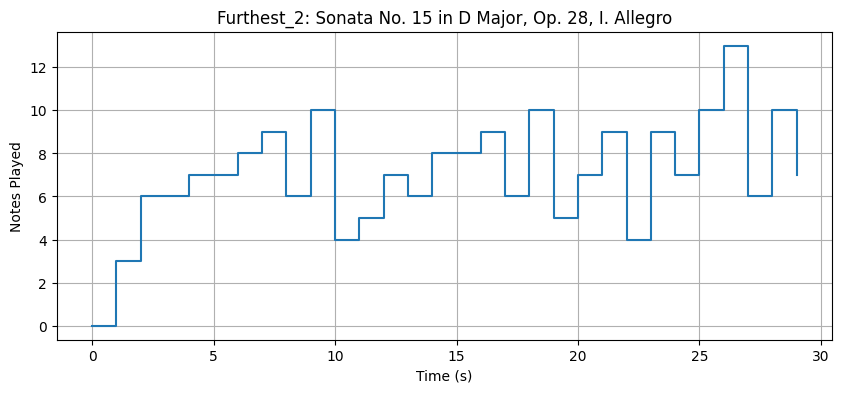

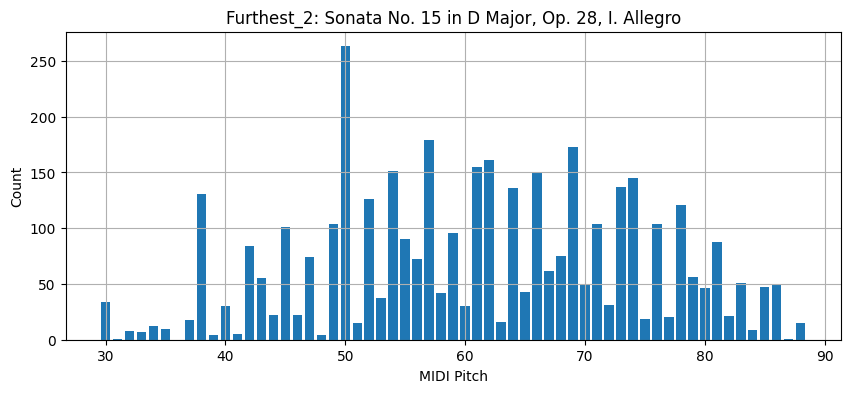


Cluster 8 - BitMidi Song: Pirates of the Caribbean - He's a Pirate (3)
BitMidi: Pirates of the Caribbean - He's a Pirate (3).mid


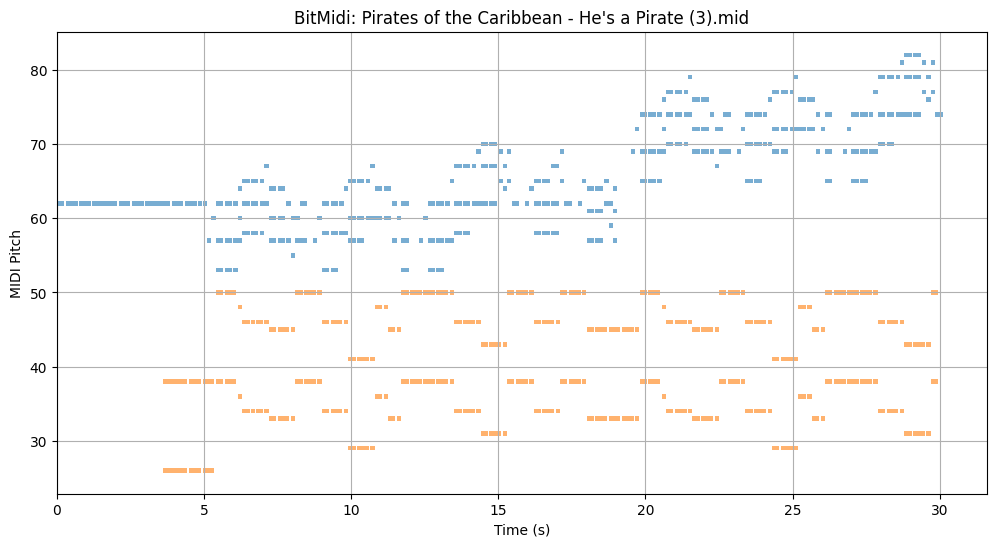

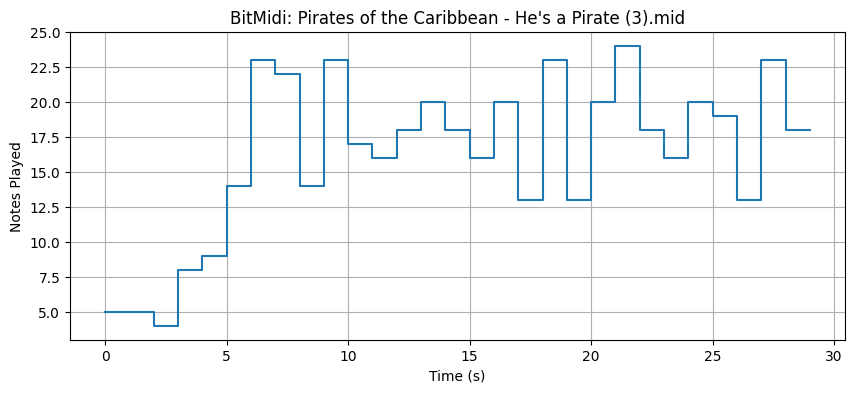

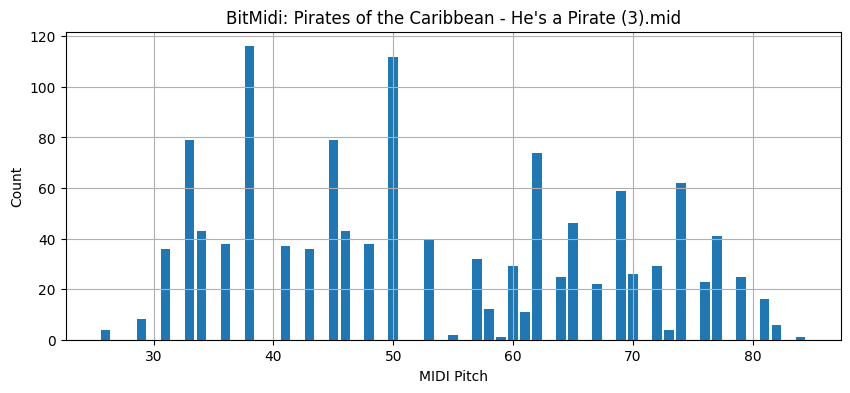

  Closest 1: Etude-Tableaux, Opus 39 No. 8 in D Minor


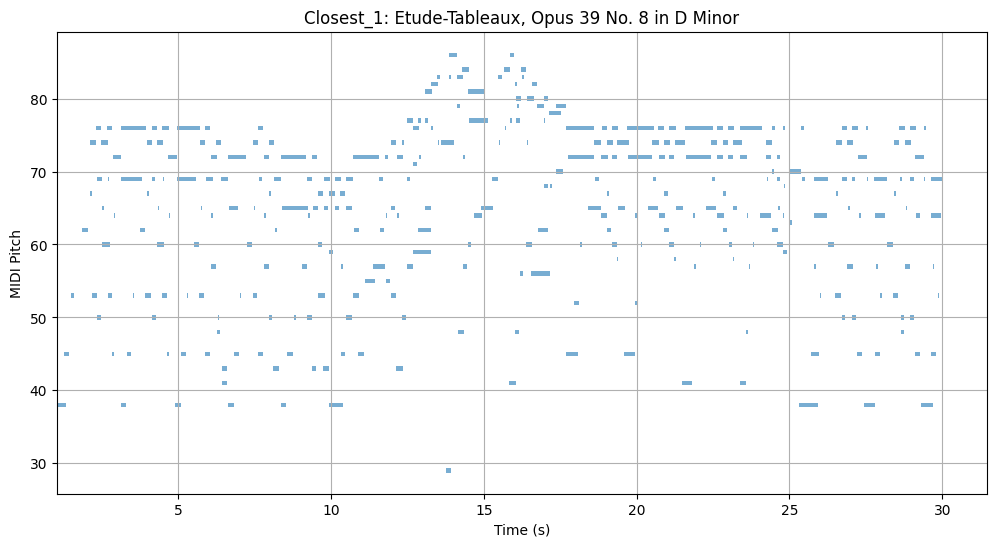

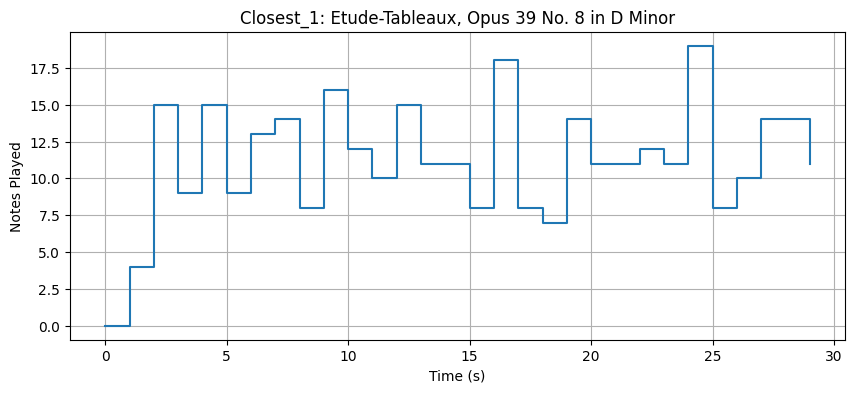

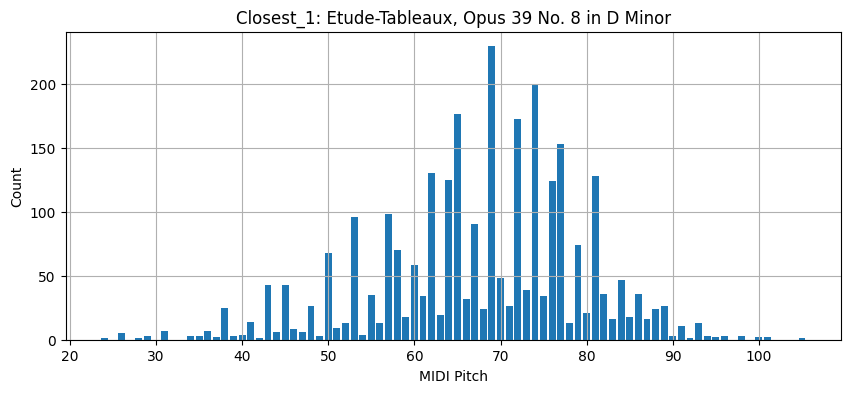

  Closest 2: Sonata in C Major, K. 132


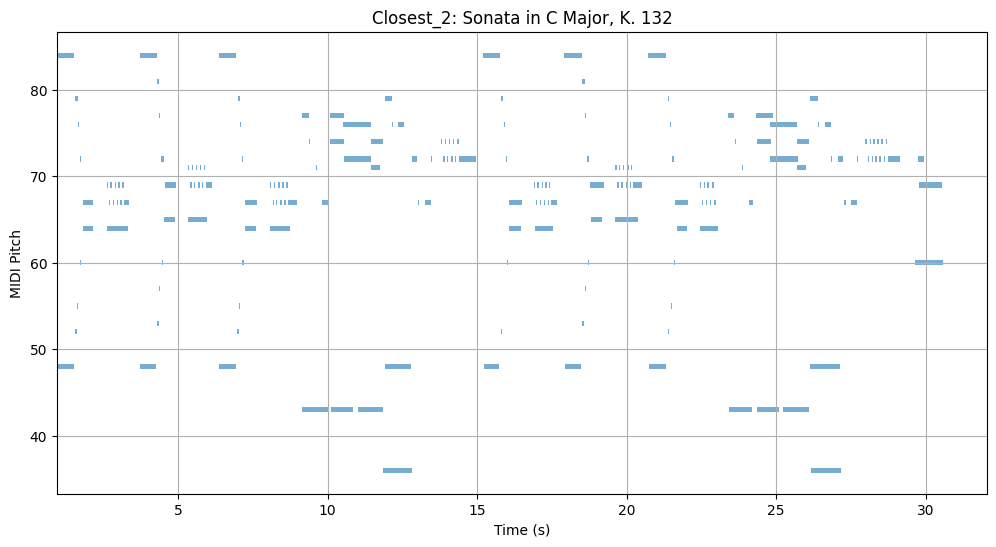

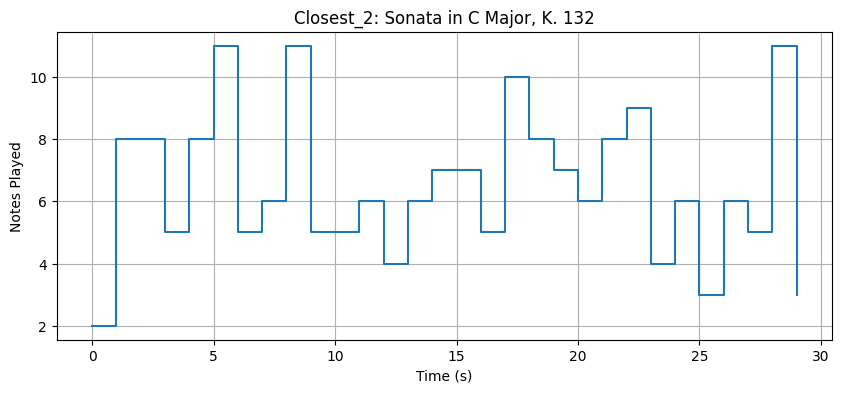

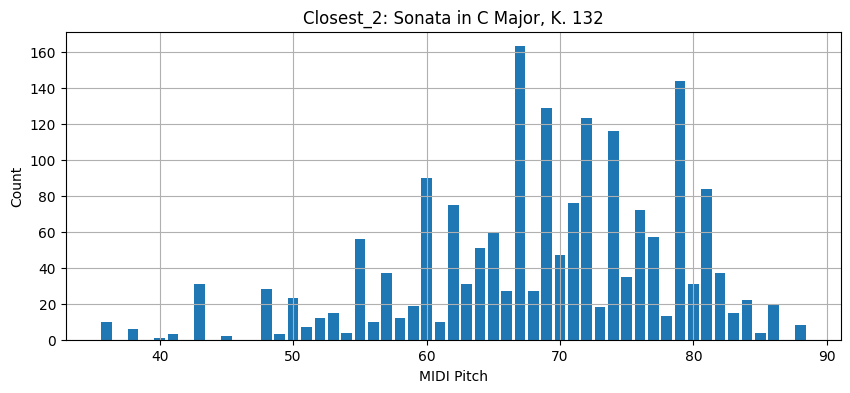

  Furthest 1: Sonata in D Minor, K. 9


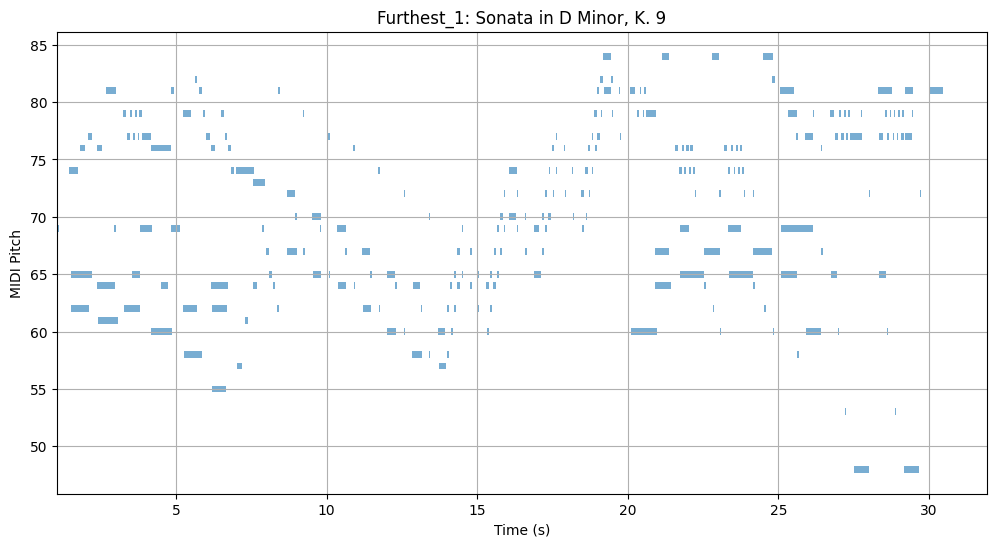

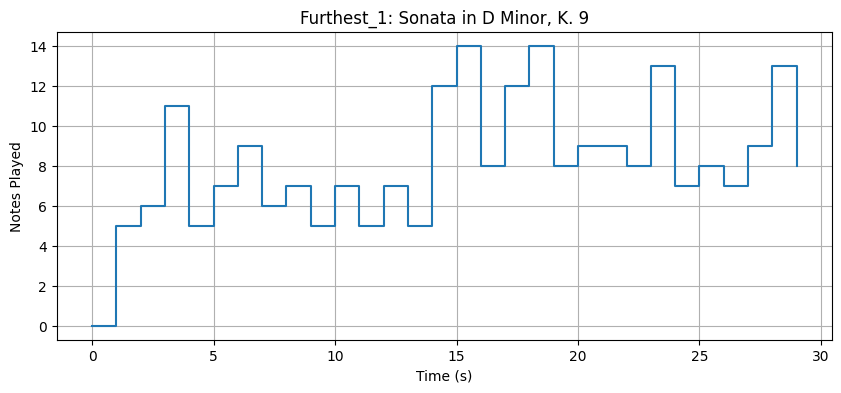

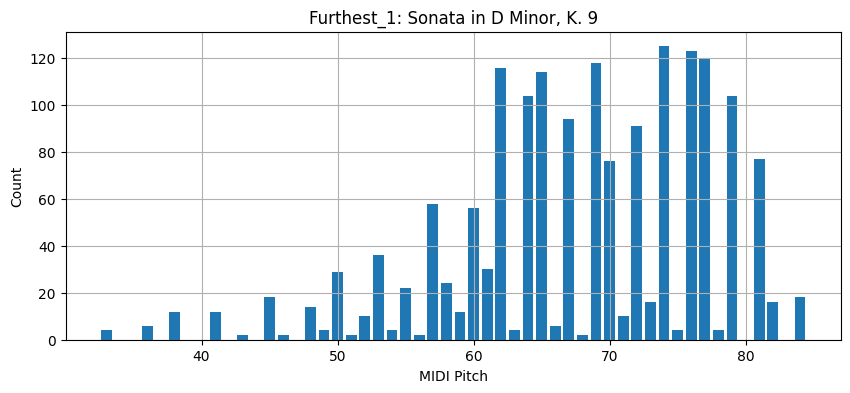

  Furthest 2: Sonata in D Minor, K. 9 L. 413


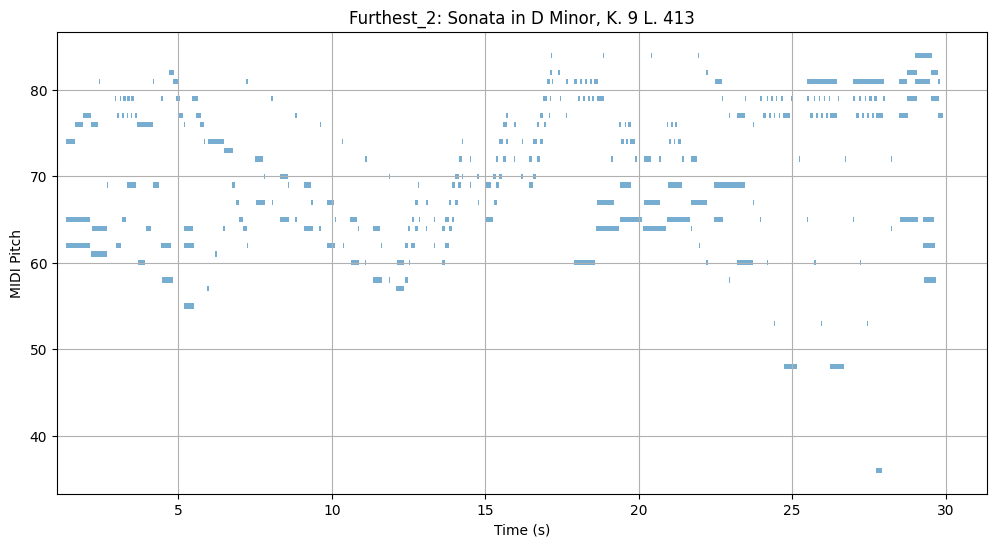

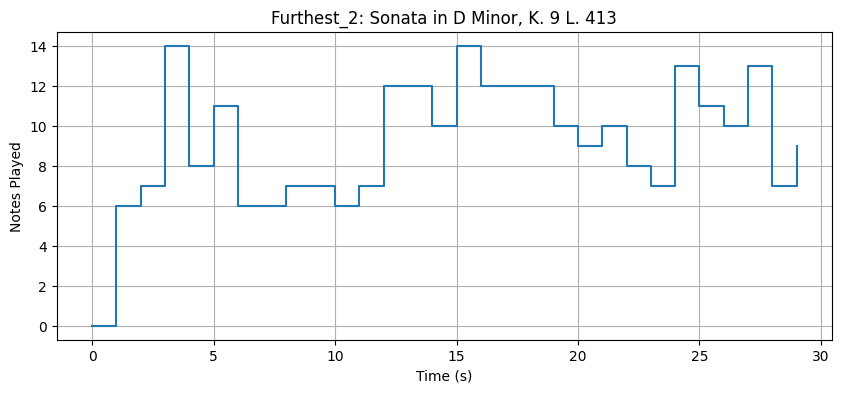

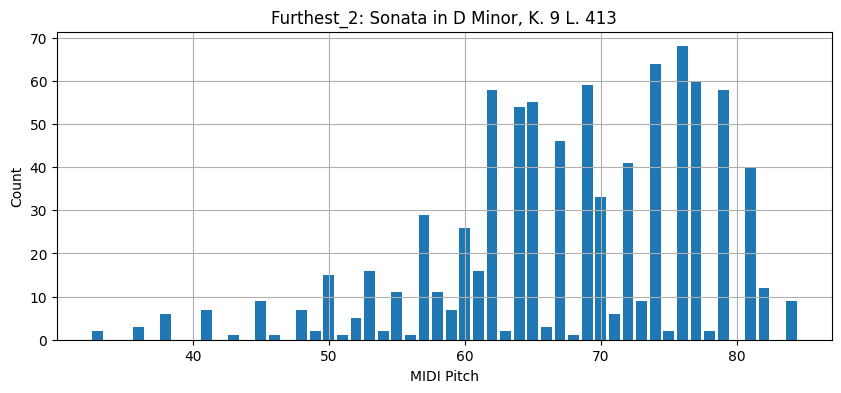

In [25]:
bitmidi_map = dict(zip(bitmidi_files, bitmidi_pretty))
maestro_map = dict(zip(test['midi_filename'], pretty_test))

for song in selected_rows['bitmidi_song'].unique():
    cluster_num = selected_rows[selected_rows['bitmidi_song'] == song]['cluster'].iloc[0]
    print(f"\nCluster {cluster_num} - BitMidi Song: {song.replace('.mid', '')}")
    
    pm_bit = bitmidi_map.get(song)
    if pm_bit:
        print(f"BitMidi: {song}")
        plot_piano_roll(pm_bit, f"BitMidi: {song}")
        plot_note_density(pm_bit, f"BitMidi: {song}")
        plot_pitch_histogram(pm_bit, f"BitMidi: {song}")
    
    subset = selected_rows[selected_rows['bitmidi_song'] == song]
    for relation in ['closest_1', 'closest_2', 'furthest_1', 'furthest_2']:
        row = subset[subset['relation'] == relation]
        if row.empty:
            continue
        maestro_title = row['maestro_song'].values[0]
        midi_fname = test[test['canonical_title'] == maestro_title]['midi_filename'].values
        if len(midi_fname) == 0:
            print(f"Could not find PrettyMIDI for {maestro_title}")
            continue
        pm_maestro = maestro_map.get(midi_fname[0])
        if pm_maestro:
            print(f"  {relation.replace('_', ' ').capitalize()}: {maestro_title}")
            plot_piano_roll(pm_maestro, f"{relation.capitalize()}: {maestro_title}")
            plot_note_density(pm_maestro, f"{relation.capitalize()}: {maestro_title}")
            plot_pitch_histogram(pm_maestro, f"{relation.capitalize()}: {maestro_title}")
